In [3]:
import uproot4
import numpy as np
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "reco_dimuon": ak.zip({
                                            "mass": dq_dict_ak1["dimuon_mass"],
                                            "x": dq_dict_ak1["dimuon_x_vtx"],
                                            "y": dq_dict_ak1["dimuon_y_vtx"],
                                            "z": dq_dict_ak1["dimuon_z_vtx"],
                                            "chisq": dq_dict_ak1["dimuon_chisq"],
                            
                        }),
                        "truth_dimuon":ak.zip({
                                            "mass": dq_dict_ak1['truthdimuon_mass'],
                                            "x": dq_dict_ak1['truthdimuon_x_vtx'],
                                            "y": dq_dict_ak1['truthdimuon_y_vtx'],
                                            "z": dq_dict_ak1['truthdimuon_z_vtx'],
                                            "px": dq_dict_ak1['truthdimuon_px'],
                                            "py": dq_dict_ak1['truthdimuon_py'],
                                            "pz": dq_dict_ak1['truthdimuon_pz'],
                            
                        })
                       }, depth_limit=1)
    return dq_events


######## READ EVENTS
filename = "/data/t3home000/dhoang/DQ/outfiles/ApMuons_Jun2721_5k.root"
dq_events = getData(filename, treeName = 'Events')

Saving plots to:  plot/27-06-2021


In [49]:
def reco_find_residual(dq_events):
    
    #Tracks selection
    reco_select = ak.num(dq_events["Track_St1"].x) == 2 #Two tracks need to be reconstructed.
    
    reco_track_st1 = dq_events["Track_St1"][reco_select]
    truth_mass = dq_events["truth_dimuon"].mass[reco_select]
    
    #Reconstruct darkphoton dimuon momentum
    reco_dimuon_px = ak.sum(reco_track_st1.px, axis = 1)
    reco_dimuon_py = ak.sum(reco_track_st1.py, axis = 1)
    reco_dimuon_pz = ak.sum(reco_track_st1.pz, axis = 1)
    
    #Reconstruct energy
    muon_mass = 0.10566
    E1 = np.sqrt(reco_track_st1.px[:,0]**2 +\
                 reco_track_st1.py[:,0]**2 +\
                 reco_track_st1.pz[:,0]**2 +\
                 muon_mass**2)
    
    E2 = np.sqrt(reco_track_st1.px[:,1]**2 +\
                 reco_track_st1.py[:,1]**2 +\
                 reco_track_st1.pz[:,1]**2 +\
                 muon_mass**2)
    
    reco_dimuon_E = E1 + E2
    
    #Reconstruct the mass
    reco_mass = np.sqrt(reco_dimuon_E**2 -\
                       (reco_dimuon_px**2 +\
                        reco_dimuon_py**2 +\
                        reco_dimuon_pz**2))
    
    #Calculate the residual
    residual = reco_mass - truth_mass

    return np.asarray(residual), ak.mean(reco_mass)

def gaussian_fit(residual,
                 mean,
                 plot_bins = 50,
                 plot_range = (-0.5,0.5),
                 p_guess=[10, 0, 0.01],
                 residual_label = r'Reco $m_{dimuon}$ - Truth $m_{dimuon}$ [GeV]'):
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=p_guess)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [GeV]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [GeV]'%abs(popt[2]))
    plt.plot([],[], 'none', label=r'$<m>=%.2f$ [GeV]'%mean)
    plt.plot([],[], 'none', label=r'$\sigma/<m>=%.4f$ [%%]'%(abs(popt[2])/mean))
    
    #Label the axes
    plt.xlabel(residual_label)
    plt.ylabel('Normalized counts')

    plt.legend()

    plt.show()

def plot_mass_resolution(dq_events):
    
    m_residual, m_mean = reco_find_residual(dq_events)
    
    gaussian_fit(m_residual, m_mean)
    

Error for parameter esimations:  [2.42787818e+00 2.20078743e-03 1.69898028e-03]
Standard deviation (fit) is 0.020299884531952056
Mean (fit) is 0.008422819776775172


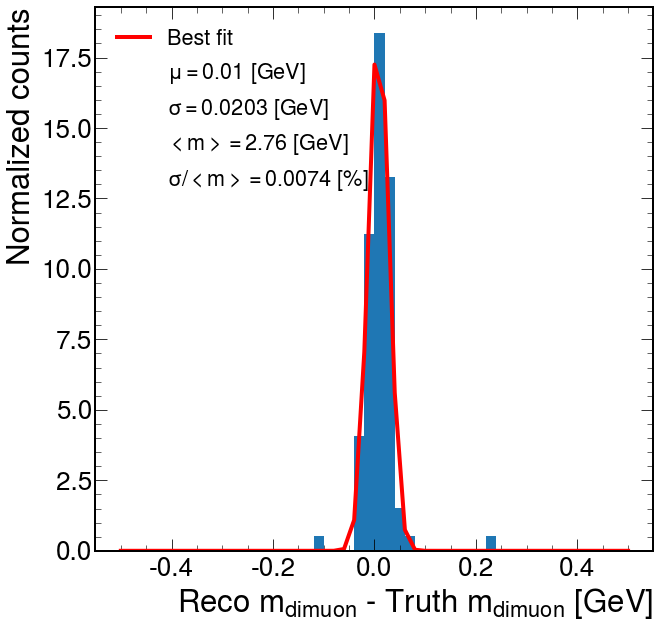

In [50]:
plot_mass_resolution(dq_events)

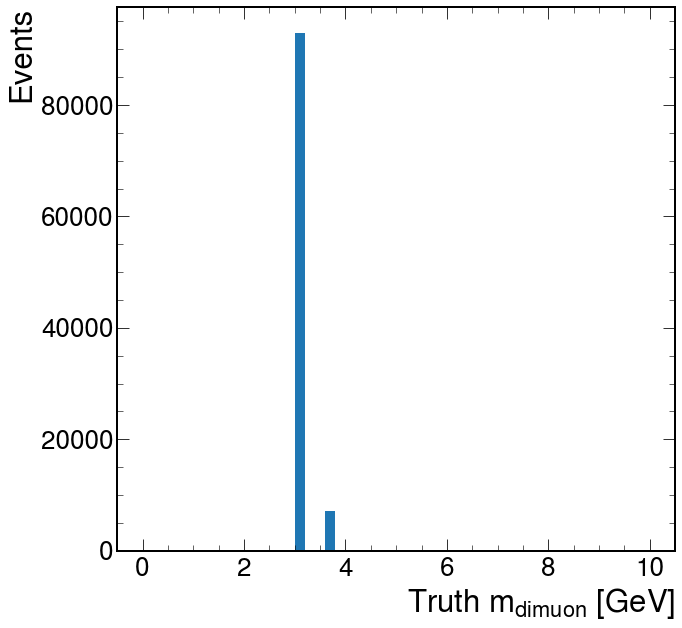

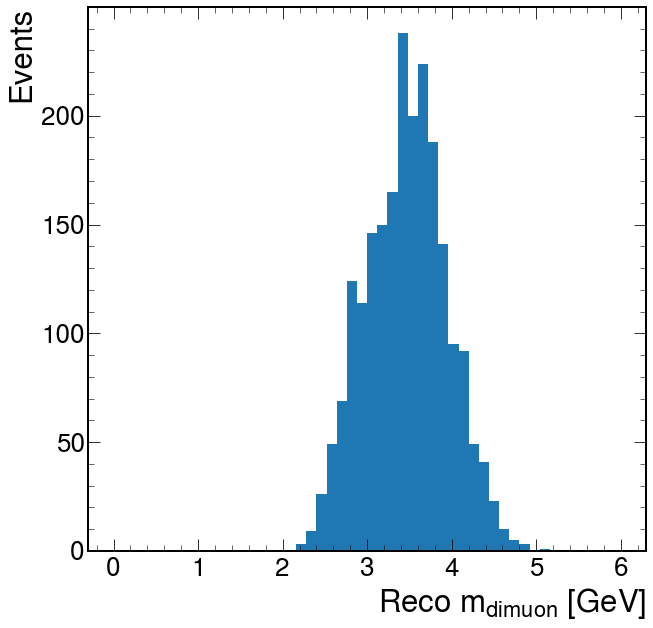

Error for parameter esimations:  [0.0420827  0.01700341 0.0117542 ]
Standard deviation (fit) is 0.42976795093835757
Mean (fit) is 0.3107934225838835


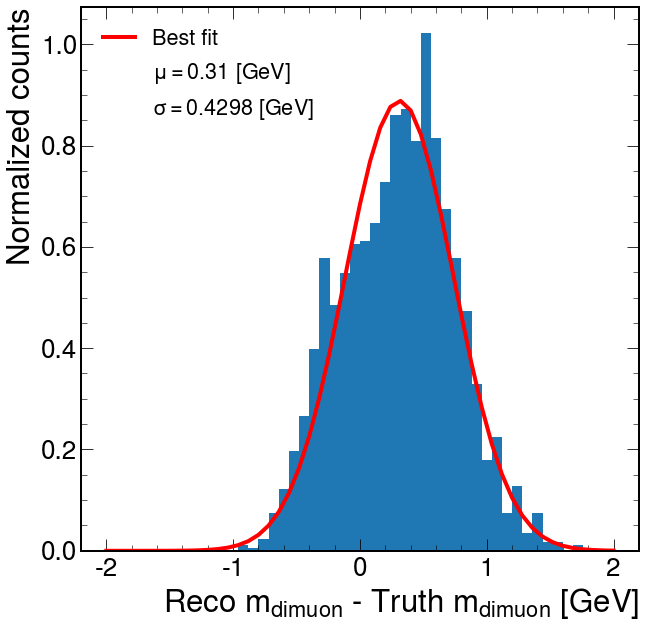

In [31]:
def plot_dy(dq_events):
    
    plot_bins = 50
    plot_range = (-2,2)
    
    #Plot truth dimuon mass
    plt.hist(ak.flatten(dq_events["truth_dimuon"].mass),
         bins = plot_bins,
         range = (0,10),
         density = False)
    plt.xlabel(r'Truth $m_{dimuon}$ [GeV]')
    plt.ylabel('Events')
    plt.show()

    #Select the events that are reconstructed
    reco_selection = (ak.count(dq_events["reco_dimuon"].mass, axis = 1) > 0) &\
                     (ak.count(dq_events["truth_dimuon"].mass, axis = 1) < 3)
                        

    reco_selected = dq_events["reco_dimuon"].mass[reco_selection]
    truth_selected = dq_events["truth_dimuon"].mass[reco_selection]
    
    #Plot reco dimuon mass
    plt.hist(reco_selected,
         bins = plot_bins,
         range = (0,6),
         density = False)
    plt.xlabel(r'Reco $m_{dimuon}$ [GeV]')
    plt.ylabel('Events')
    plt.show()
    
    m_residual = np.asarray(ak.flatten(reco_selected - truth_selected))
    
    #Plot and fit
    plt.hist(m_residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    data_entries, _ = np.histogram(m_residual, bins=bins,
                                   range = plot_range, density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=[1, 0, 0.2])
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [GeV]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [GeV]'%abs(popt[2]))
    
    #Label the axes
    plt.xlabel(r'Reco $m_{dimuon}$ - Truth $m_{dimuon}$ [GeV]')
    plt.ylabel('Normalized counts')

    plt.legend()

    plt.show()
    
    
plot_dy(dq_events)

## Momentum rms versus p

No handles with labels found to put in legend.


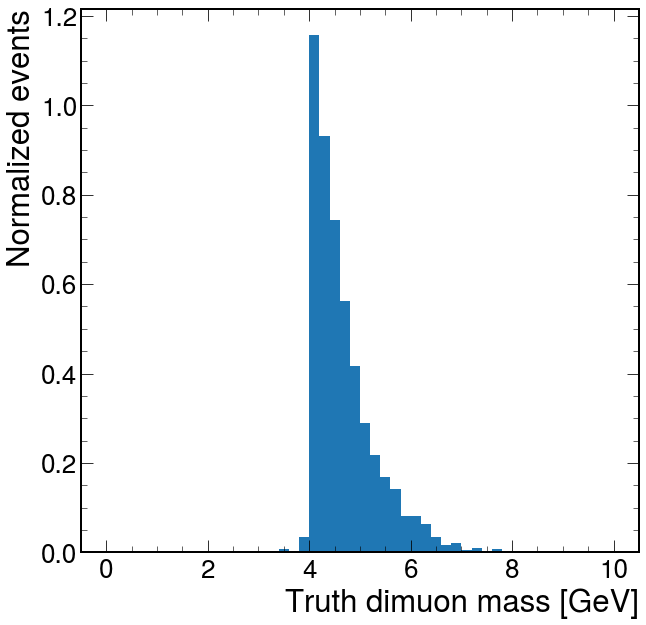

No handles with labels found to put in legend.


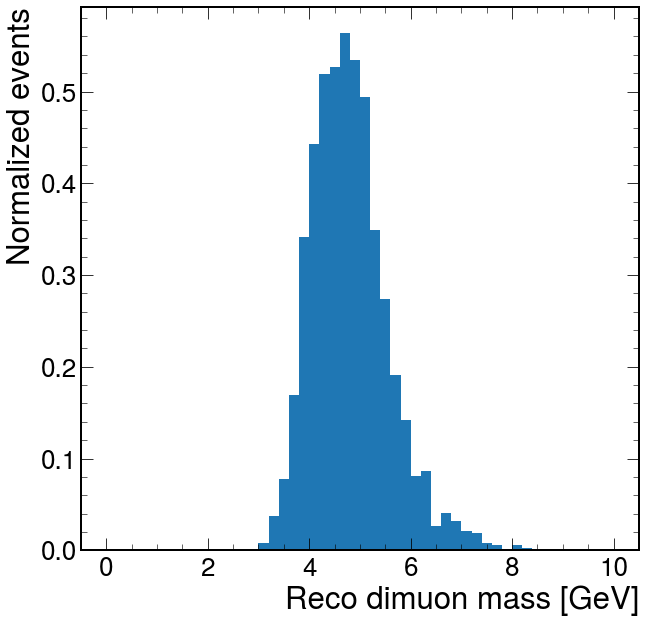

Truth momentum range: 60,80 GeV
Error for parameter esimations:  [0.05754464 0.02586547 0.01850467]
Standard deviation (fit) is 0.44264558996651127
Mean (fit) is 0.18834617150094116


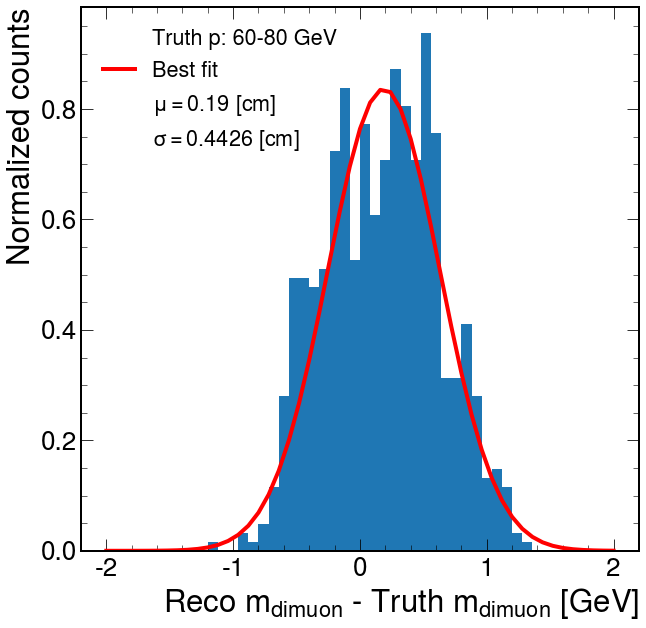

Truth momentum range: 80,100 GeV
Error for parameter esimations:  [0.04763972 0.02315749 0.0166919 ]
Standard deviation (fit) is 0.4640449095395903
Mean (fit) is 0.09475715770945696


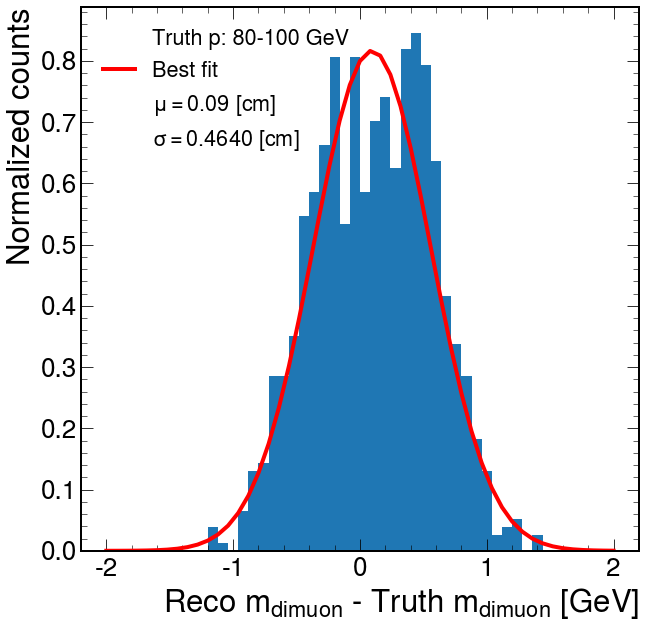

Truth momentum range: 100,120 GeV
Error for parameter esimations:  [0.07352705 0.04337876 0.04097166]
Standard deviation (fit) is 0.49985787382154884
Mean (fit) is 0.1553479706998697


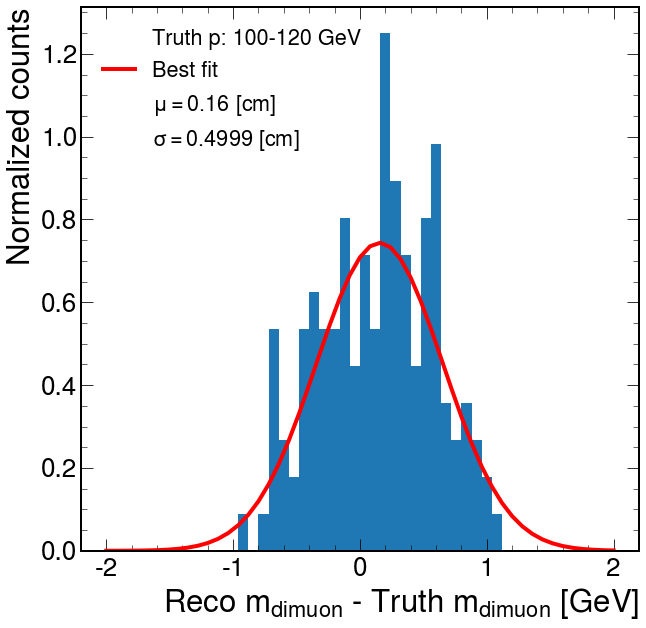

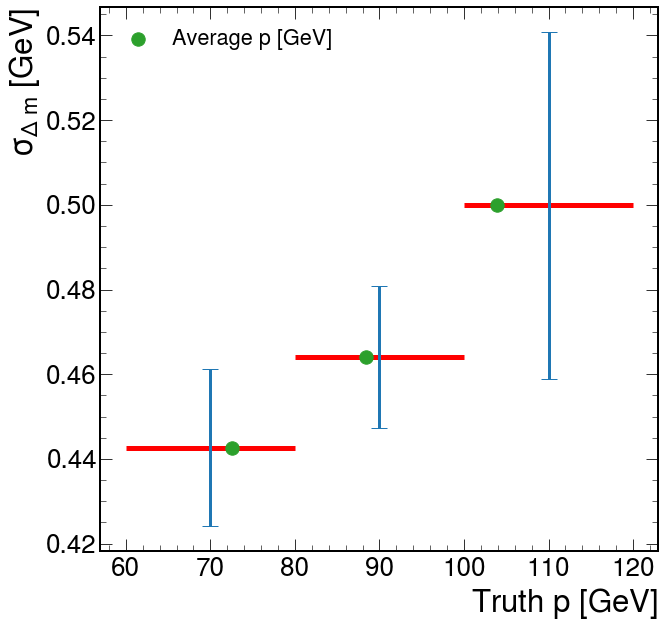

In [5]:
def rms_p(dq_events):
    
    plot_bins = 50
    plot_range = (-2,2)
    
    #Select the events that are reconstructed
    reco_selection = ak.any(dq_events["reco_dimuon"].mass, axis = 1)

    dy_selected = dq_events["reco_dimuon"].mass[reco_selection]
    truth_selected = dq_events["truth_dimuon"].mass[reco_selection]
    
    ##plot the truth and reconstructed momentum
    plt.hist(truth_selected,
             bins = plot_bins,
             range = (0, 10),
             density = True)
    plt.xlabel(r"Truth dimuon mass [GeV]")
    plt.ylabel("Normalized events")
    plt.legend()
    plt.show()
    
    ##plot the truth and reconstructed momentum
    plt.hist(dy_selected,
             bins = plot_bins,
             range = (0, 10),
             density = True)
    plt.xlabel(r"Reco dimuon mass [GeV]")
    plt.ylabel("Normalized events")
    plt.legend()
    plt.show()
    
    #Select the truth momentum range as well
    truth_p_selected = np.linalg.norm([ak.flatten(dq_events["truth_dimuon"].px[reco_selection]),
                                       ak.flatten(dq_events["truth_dimuon"].py[reco_selection]),
                                       ak.flatten(dq_events["truth_dimuon"].pz[reco_selection])],axis = 0)
    
    m_resolution = [] #To save the resolution (sigma) of the fit
    m_err = []
    p_ranges = []
    p_average = []
    
    
    #Loop over different average p range
    for i in range(3):
        
        p_range = 20
        p_min = i*p_range + 60 #GeV
        p_max = (i+1)*p_range + 60
        p_ranges.append([p_min,p_max]) #Save for plotting resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (truth_p_selected > p_min) & (truth_p_selected < p_max)
        p_average.append(np.mean(truth_p_selected[local_selection]))
        
        residual = copy.deepcopy(np.asarray(dy_selected[local_selection] - truth_selected[local_selection]))
    
#         #Initial distribution of momentum
#         plt.hist(truth_p_selected[local_selection],
#                  bins = plot_bins,
#                  range = (p_min-5, p_max+5),
#                  density = True)
#         plt.plot([],[], 'none', label="Truth p: {}-{} GeV".format(p_min, p_max))
#         plt.xlabel(r"Truth p [GeV]")
#         plt.ylabel("Normalized events")
#         plt.legend()
#         plt.show()
        
        
        #Initial distribution of mass residual
        plt.hist(residual ,
                 bins = plot_bins,
                 range = plot_range,
                 density = True)
        plt.plot([],[], 'none', label="Truth p: {}-{} GeV".format(p_min, p_max))
        
        
        ## Gaussian fit
        ## Fit directly on the histogram
        def fit_function(x, A, mu, sig):
            return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

        bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        data_entries, _ = np.histogram(residual, bins=bins,
                                       range = plot_range, density = True)

        mask = data_entries!=0
        #Fit the function to the histogram data.
        popt, pcov = curve_fit(fit_function,
                               xdata=binscenters[mask],
                               ydata=data_entries[mask],
                               sigma = np.sqrt(data_entries[mask]),
                               absolute_sigma = False,
                               p0=[0.1, 0, 0.5])


        #Error for parameter estimations
        perr = np.sqrt(np.diag(pcov))
        print("Error for parameter esimations: ", perr)
        m_err.append(perr[2])

        std_fit = np.abs(popt[2])
        mean_fit = popt[1]
        m_resolution.append(std_fit)

        print("Standard deviation (fit) is", std_fit)
        print("Mean (fit) is", mean_fit)

        #Plot fitted gaussian
        plt.plot(bins,
                 fit_function(bins, *popt),
                 "r-",
                 linewidth=4,
                 label='Best fit')

        plt.plot([],[], 'none', label=r'$\mu=%.2f$ [cm]'%popt[1])
        plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [cm]'%abs(popt[2]))

        #Label the axes
        plt.xlabel(r'Reco $m_{dimuon}$ - Truth $m_{dimuon}$ [GeV]')
        plt.ylabel('Normalized counts')
        
        plt.legend()
        plt.show()
        
    
    ###### Plot resolution versus momentum
    #Plot momentum average
    plt.scatter(p_average, m_resolution, s=180, c='#2ca02c', label = "Average p [GeV]", zorder = 10)
    
    plt.hlines(m_resolution,
               [x[0] for x in p_ranges],
               [x[1] for x in p_ranges],
               colors='r', lw=5,
               linestyles='solid')

    #Plot the error bars
    plt.errorbar([np.average(x) for x in p_ranges],
                m_resolution,
                yerr=m_err,
                fmt='none',
                elinewidth=3,
                capsize=8)
    plt.xlabel(r'Truth $p$ [GeV]')
    plt.ylabel(r'$\sigma_{\Delta~m}$ [GeV]')
    
    plt.legend()
    plt.show()
    
    
rms_p(dq_events)   

In [51]:
np.sqrt((-1.46)**2 + 0.607**2 + 83**2)

83.01505917000843

## Z resolution

Error for parameter esimations:  [2.93823321e-04 1.55197042e+00 1.11780704e+00]
Standard deviation (fit) is 49.70785081497315
Mean (fit) is 6.224633809766793


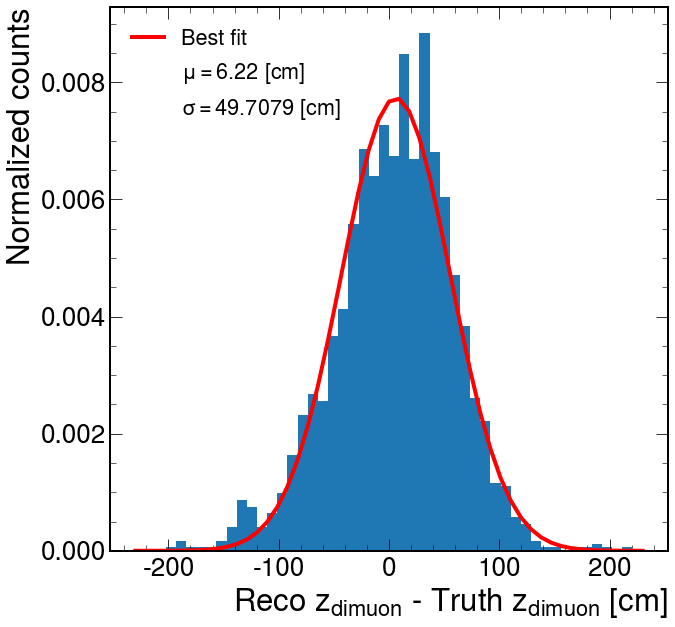

In [13]:
def z_res(dq_events):
    
    plot_bins = 50
    plot_range = (-230,230)
    
    #Select the events that are reconstructed
    reco_selection = ak.any(dq_events["reco_dimuon"].z, axis = 1)

    dy_selected = dq_events["reco_dimuon"].z[reco_selection]
    truth_selected = dq_events["truth_dimuon"].z[reco_selection]
    
    residual = np.asarray(ak.flatten(dy_selected - truth_selected))
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range, density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=[0.01, 0, 50])
    
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [cm]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [cm]'%abs(popt[2]))
    
    #Label the axes
    plt.xlabel(r'Reco $z_{dimuon}$ - Truth $z_{dimuon}$ [cm]')
    plt.ylabel('Normalized counts')

    plt.legend()

    plt.show()
    
z_res(dq_events)


## Muons matching & pz resolution

Truth momentum range: 0,30 GeV
Error for parameter esimations:  [0.04584225 0.00887252 0.00685831]
Standard deviation (fit) is 0.3076350226733627
Mean (fit) is -0.0007498561541044583
Resolution (fit) is -410.25871560761743


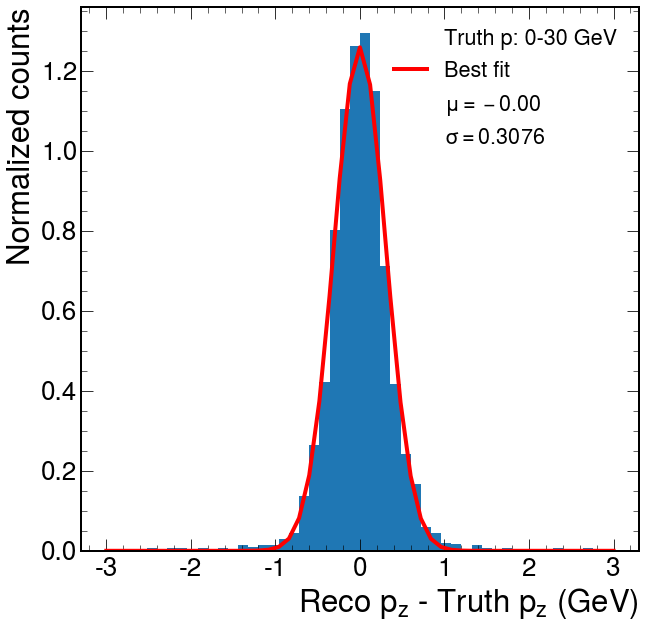

Truth momentum range: 30,60 GeV
Error for parameter esimations:  [0.02612818 0.0119132  0.00915272]
Standard deviation (fit) is 0.4721809572381475
Mean (fit) is -0.01932550475591455
Resolution (fit) is -24.433046546617987


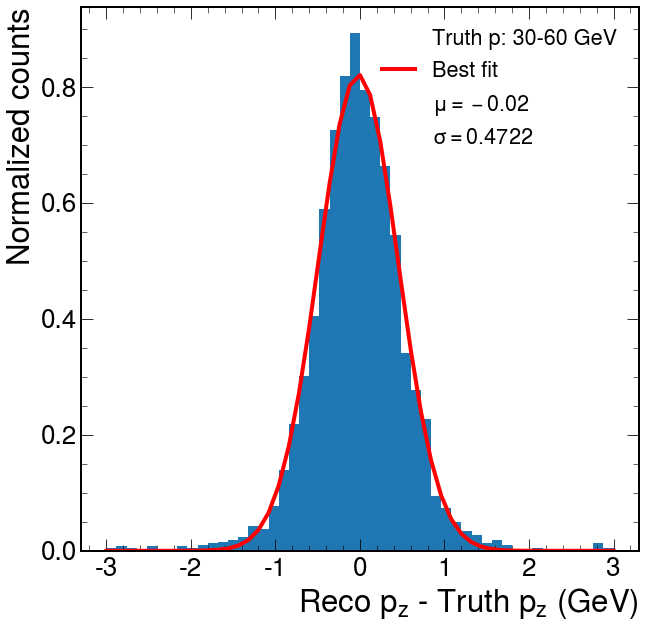

Truth momentum range: 60,90 GeV
Error for parameter esimations:  [0.05245408 0.35578858 0.55845682]
Standard deviation (fit) is 1.5162092291014213
Mean (fit) is -0.19927365787365836
Resolution (fit) is -7.608678664706974


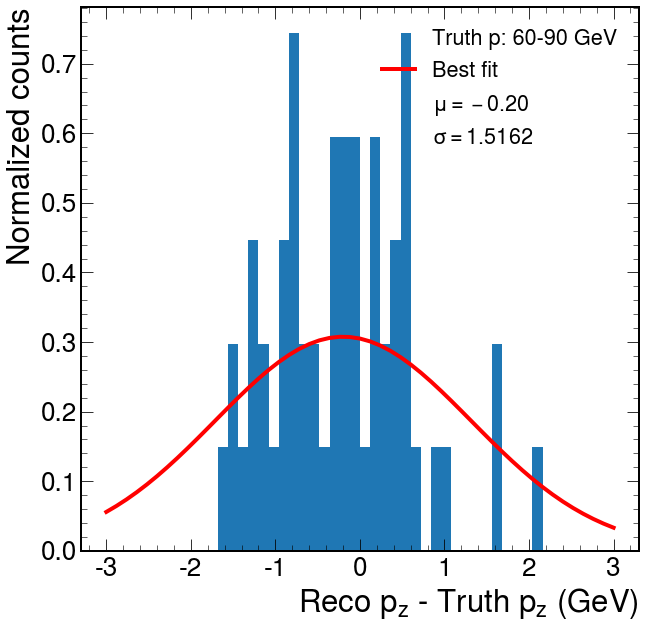

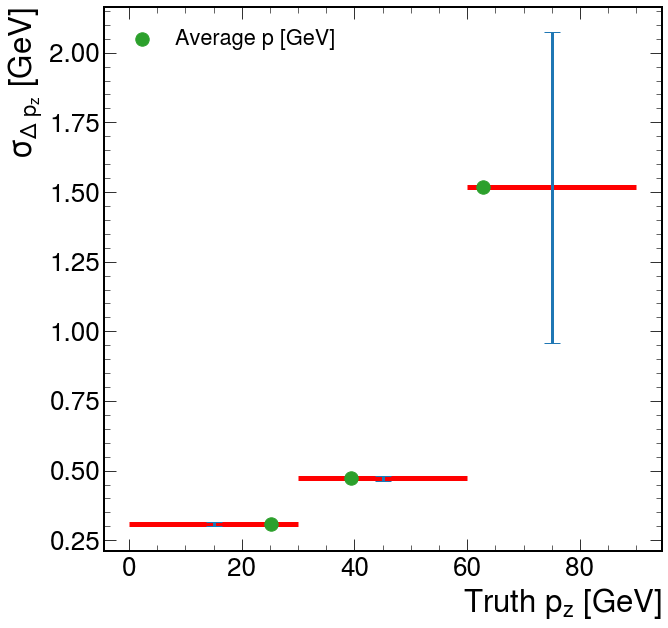

In [7]:
def processor(dq_events):
    
    GenMuons = dq_events['GenP_St1']
    RecoMuons = dq_events["Track_St1"]
    GenVertices = dq_events['GenVertex']
    nTracks = dq_events['nTrack']
    
    #Dictionary to hold saved arrays
    track_dict = {}
    
    # only look at the events with two tracks reconstructed for now
    # because it is easier to match the pz
    for num_track in [1,2]:
        events_selected = (nTracks.n_tracks == num_track)
        RecoMuons_selected = RecoMuons[events_selected]
        GenMuons_selected = GenMuons[events_selected]
        GenVertices_selected = GenVertices[events_selected]
        
        if num_track == 1:
            #Match based on the closest pz
            match_index = ak.argmin(abs(GenMuons_selected.pz - ak.flatten(RecoMuons_selected.pz)),
                                    axis=1, keepdims=True)
            
            track_dict['truth_pz_1track'] = GenMuons_selected[match_index].pz
            track_dict['reco_pz_1track'] = RecoMuons_selected.pz #since there is only 1 track
            
        elif num_track == 2:
            #Max case
            index_gen_pzmax = ak.argmax(GenMuons_selected.pz, axis=1, keepdims=True)
            index_reco_pzmax = ak.argmax(RecoMuons_selected.pz, axis=1, keepdims=True)
            
            
            track_dict['truth_pz_max2track'] = GenMuons_selected[index_gen_pzmax].pz
            track_dict['reco_pz_max2track'] = RecoMuons_selected[index_reco_pzmax].pz
            
            #Min case
            index_gen_pzmin = ak.argmin(GenMuons_selected.pz, axis=1, keepdims=True)
            index_reco_pzmin = ak.argmin(RecoMuons_selected.pz, axis=1, keepdims=True)
            
            track_dict['truth_pz_min2track'] = GenMuons_selected[index_gen_pzmin].pz
            track_dict['reco_pz_min2track'] = RecoMuons_selected[index_reco_pzmin].pz
    
    
    #Concatenate the matched tracks together
    all_truth_pz = np.asarray(ak.flatten(np.concatenate([track_dict['truth_pz_1track'],
                                      track_dict['truth_pz_max2track'],
                                      track_dict['truth_pz_min2track']])))
    
    all_reco_pz =  np.asarray(ak.flatten(np.concatenate([track_dict['reco_pz_1track'],
                                     track_dict['reco_pz_max2track'],
                                     track_dict['reco_pz_min2track']])))
    
    p_resolution = [] #To save the resolution (sigma) of the fit
    p_average = []
    p_ranges = []
    p_err = []
    
    #Specify the ranges to calculate the resolution in 
    for i in list(range(3)):
        
        p_range = 30
        p_min = i*p_range #GeV
        p_max = (i+1)*p_range
        p_ranges.append([p_min,p_max]) #Save for resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (all_truth_pz > p_min) & (all_truth_pz < p_max)
        p_average.append(np.mean(all_truth_pz[local_selection]))
        
        p_residual = copy.deepcopy(all_reco_pz[local_selection] - all_truth_pz[local_selection])
        
        #Initial distribution and labelling
        plt.hist(p_residual,
                 bins = 50,
                 range = (-3, 3),
                 density = True)
        plt.plot([],[], 'none', label="Truth p: {}-{} GeV".format(p_min, p_max))
        
        ## Gaussian fit
        ## Fit directly on the histogram
        def fit_function(x, A, mu, sig):
            return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

        bins = np.linspace(-3, 3, 51)
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        data_entries, _ = np.histogram(p_residual, bins=bins,
                                       range = (-3, 3), density = True)

        mask = data_entries!=0
        #Fit the function to the histogram data.
        popt, pcov = curve_fit(fit_function,
                               xdata=binscenters[mask],
                               ydata=data_entries[mask],
                               sigma = np.sqrt(data_entries[mask]),
                               absolute_sigma = False,
                               p0=[1, 0, 0.5])

        #Error for parameter estimations
        perr = np.sqrt(np.diag(pcov))
        print("Error for parameter esimations: ", perr)
        p_err.append(perr[2])

        std_fit = np.abs(popt[2])
        mean_fit = popt[1]
        res_fit = std_fit/mean_fit
        sigma_res = perr[2]/mean_fit
        print("Standard deviation (fit) is", std_fit)
        print("Mean (fit) is", mean_fit)
        print("Resolution (fit) is {}".format(res_fit))
        p_resolution.append(std_fit)

        #Plot fitted gaussian
        plt.plot(bins,
                 fit_function(bins, *popt),
                 "r-",
                 linewidth=4,
                 label='Best fit')
        
        plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
        plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%popt[2])
        
        #Label the axes
        plt.xlabel(r'Reco $p_z$ - Truth $p_z$ (GeV)')
        plt.ylabel('Normalized counts')
        
        plt.legend()
        plt.show()
        
        
    #MAIN PLOT
    #Plot momentum average
    plt.scatter(p_average, p_resolution, s=180, c='#2ca02c', label = "Average p [GeV]", zorder = 10)
    
    #Plot the resolution based on momentum range. 
    plt.hlines(p_resolution,
               [x[0] for x in p_ranges],
               [x[1] for x in p_ranges],
               colors='r', lw=5,
               linestyles='solid')

    #Plot the error bars
    plt.errorbar([np.average(x) for x in p_ranges],
                p_resolution,
                yerr=p_err,
                fmt='none',
                elinewidth=3,
                capsize=8)
    plt.xlabel(r'Truth $p_z$ [GeV]')
    plt.ylabel(r'$\sigma_{\Delta~p_z}$ [GeV]')
    
    plt.legend()
    plt.show()
    
processor(dq_events)

## Scale up to px, and py

Truth momentum range: 0,30 GeV
Error for parameter esimations:  [2.62451533e+00 4.67219495e-04 3.90992349e-04]
Standard deviation (fit) is 0.00931154199457558
Mean (fit) is -0.00040417202119502886
Resolution (fit) is -23.03856156852182


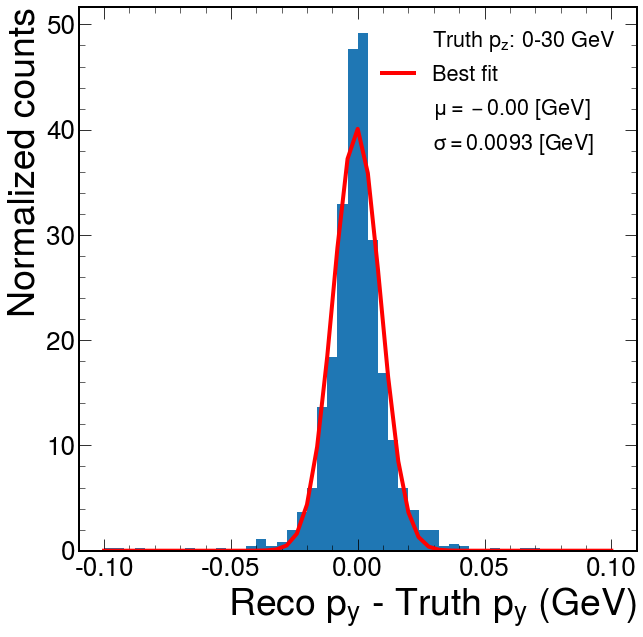

Truth momentum range: 30,60 GeV
Error for parameter esimations:  [2.31718093e+00 4.96105065e-04 4.20930471e-04]
Standard deviation (fit) is 0.01014075027381274
Mean (fit) is 7.280227226364984e-05
Resolution (fit) is 139.29167261549904


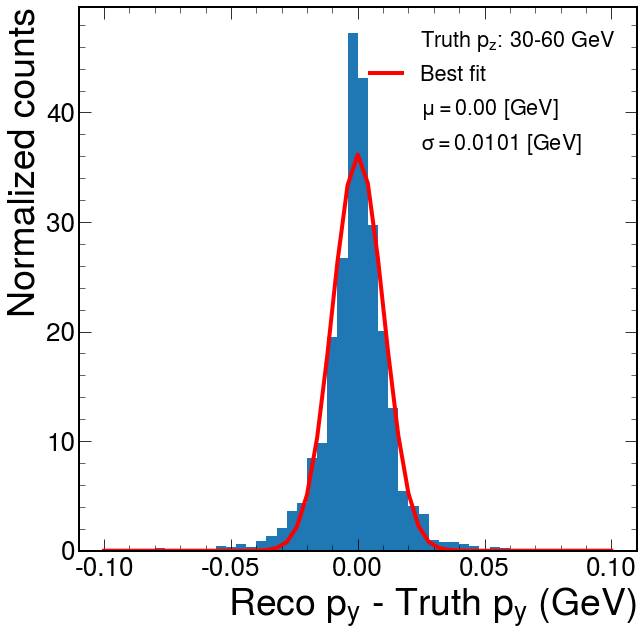

Truth momentum range: 60,90 GeV
Error for parameter esimations:  [3.48664223e+00 5.33274613e-04 4.78992145e-04]
Standard deviation (fit) is 0.008454573762532962
Mean (fit) is -0.00014082133547127976
Resolution (fit) is -60.03759113800803


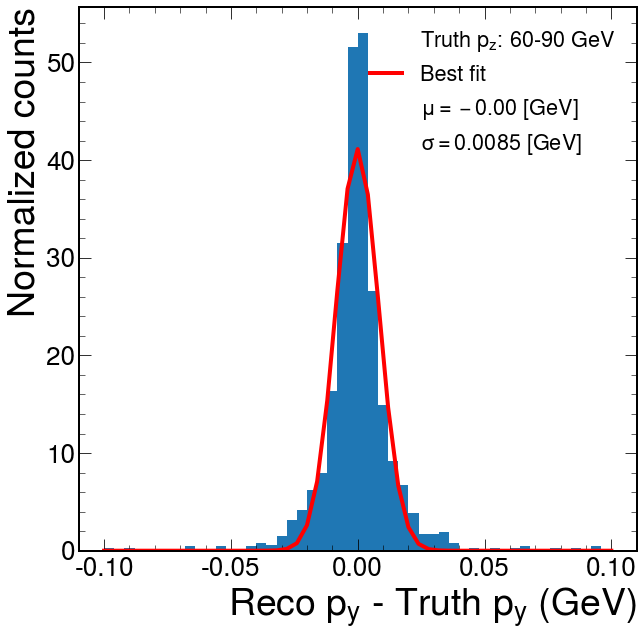

Truth momentum range: 90,120 GeV
Error for parameter esimations:  [1.01996152e+01 4.76603326e-04 4.09743905e-04]
Standard deviation (fit) is 0.004625801186735456
Mean (fit) is -0.000273556431061943
Resolution (fit) is -16.909860860438


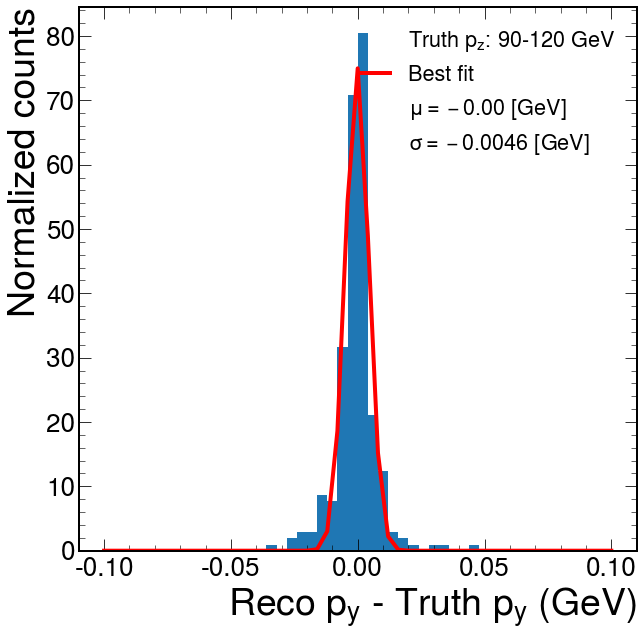

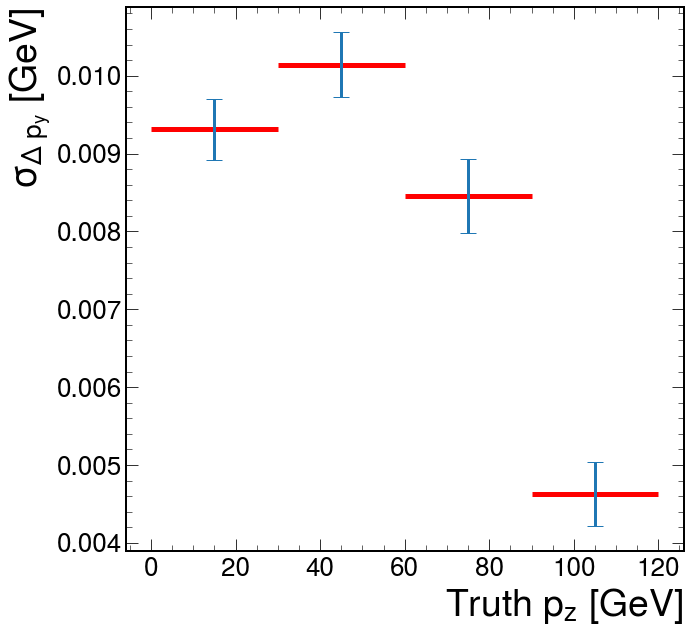

In [11]:
def processor(dq_events):
    
    GenMuons = dq_events['GenP_St1']
    RecoMuons = dq_events["Track_St1"]
    GenVertices = dq_events['GenVertex']
    nTracks = dq_events['nTrack']
    
    #Dictionary to hold saved arrays
    track_dict = {}
    
    # only look at the events with two tracks reconstructed for now
    # because it is easier to match the pz
    for num_track in [1,2]:
        events_selected = (nTracks.n_tracks == num_track)
        RecoMuons_selected = RecoMuons[events_selected]
        GenMuons_selected = GenMuons[events_selected]
        GenVertices_selected = GenVertices[events_selected]
        
        if num_track == 1:
            #Match based on the closest pz
            match_index = ak.argmin(abs(GenMuons_selected.pz - ak.flatten(RecoMuons_selected.pz)),
                                    axis=1, keepdims=True)
            
            track_dict['truth_pz_1track'] = GenMuons_selected[match_index].pz
            track_dict['reco_pz_1track'] = RecoMuons_selected.pz #since there is only 1 track
            
            track_dict['truth_px_1track'] = GenMuons_selected[match_index].px
            track_dict['reco_px_1track'] = RecoMuons_selected.px #since there is only 1 track
            
            track_dict['truth_py_1track'] = GenMuons_selected[match_index].py
            track_dict['reco_py_1track'] = RecoMuons_selected.py #since there is only 1 track
            
        elif num_track == 2:
            #Max case
            index_gen_pzmax = ak.argmax(GenMuons_selected.pz, axis=1, keepdims=True)
            index_reco_pzmax = ak.argmax(RecoMuons_selected.pz, axis=1, keepdims=True)
            
            
            track_dict['truth_pz_max2track'] = GenMuons_selected[index_gen_pzmax].pz
            track_dict['reco_pz_max2track'] = RecoMuons_selected[index_reco_pzmax].pz
            
            track_dict['truth_px_max2track'] = GenMuons_selected[index_gen_pzmax].px
            track_dict['reco_px_max2track'] = RecoMuons_selected[index_reco_pzmax].px
            
            track_dict['truth_py_max2track'] = GenMuons_selected[index_gen_pzmax].py
            track_dict['reco_py_max2track'] = RecoMuons_selected[index_reco_pzmax].py
            
            #Min case
            index_gen_pzmin = ak.argmin(GenMuons_selected.pz, axis=1, keepdims=True)
            index_reco_pzmin = ak.argmin(RecoMuons_selected.pz, axis=1, keepdims=True)
            
            track_dict['truth_pz_min2track'] = GenMuons_selected[index_gen_pzmin].pz
            track_dict['reco_pz_min2track'] = RecoMuons_selected[index_reco_pzmin].pz
            
            track_dict['truth_px_min2track'] = GenMuons_selected[index_gen_pzmin].px
            track_dict['reco_px_min2track'] = RecoMuons_selected[index_reco_pzmin].px
            
            track_dict['truth_py_min2track'] = GenMuons_selected[index_gen_pzmin].py
            track_dict['reco_py_min2track'] = RecoMuons_selected[index_reco_pzmin].py
    
    
    #Concatenate the matched tracks together
    all_truth_pz = np.asarray(ak.flatten(np.concatenate([track_dict['truth_pz_1track'],
                                      track_dict['truth_pz_max2track'],
                                      track_dict['truth_pz_min2track']])))
    
    all_reco_pz =  np.asarray(ak.flatten(np.concatenate([track_dict['reco_pz_1track'],
                                     track_dict['reco_pz_max2track'],
                                     track_dict['reco_pz_min2track']])))
    
    all_truth_px = np.asarray(ak.flatten(np.concatenate([track_dict['truth_px_1track'],
                                      track_dict['truth_px_max2track'],
                                      track_dict['truth_px_min2track']])))
    
    all_reco_px =  np.asarray(ak.flatten(np.concatenate([track_dict['reco_px_1track'],
                                     track_dict['reco_px_max2track'],
                                     track_dict['reco_px_min2track']])))
    
    all_truth_py = np.asarray(ak.flatten(np.concatenate([track_dict['truth_py_1track'],
                                      track_dict['truth_py_max2track'],
                                      track_dict['truth_py_min2track']])))
    
    all_reco_py =  np.asarray(ak.flatten(np.concatenate([track_dict['reco_py_1track'],
                                     track_dict['reco_py_max2track'],
                                     track_dict['reco_py_min2track']])))
    
    p_resolution = [] #To save the resolution (sigma) of the fit
    p_ranges = []
    p_err = []
    
    #Specify the ranges to calculate the resolution in 
    for i in list(range(4)):
        
        p_range = 30
        p_min = i*p_range #GeV
        p_max = (i+1)*p_range
        p_ranges.append([p_min,p_max]) #Save for resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (all_truth_pz > p_min) & (all_truth_pz < p_max)
        
        p_residual = copy.deepcopy(all_reco_py[local_selection] - all_truth_py[local_selection])
        
        residual_range = (-0.1, 0.1)
        #Initial distribution and labelling
        plt.hist(p_residual,
                 bins = 50,
                 range = residual_range,
                 density = True)
        plt.plot([],[], 'none', label=r"Truth $p_z$: {}-{} GeV".format(p_min, p_max))
        
        ## Gaussian fit
        ## Fit directly on the histogram
        def fit_function(x, A, mu, sig):
            return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

        bins = np.linspace(residual_range[0], residual_range[1], 51)
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        data_entries, _ = np.histogram(p_residual, bins=bins,
                                       range = residual_range, density = True)

        mask = data_entries!=0
        #Fit the function to the histogram data.
        popt, pcov = curve_fit(fit_function,
                               xdata=binscenters[mask],
                               ydata=data_entries[mask],
                               sigma = np.sqrt(data_entries[mask]),
                               absolute_sigma = False,
                               p0=[5, 0, 0.05])

        #Error for parameter estimations
        perr = np.sqrt(np.diag(pcov))
        print("Error for parameter esimations: ", perr)
        p_err.append(perr[2])

        std_fit = np.abs(popt[2])
        mean_fit = popt[1]
        res_fit = std_fit/mean_fit
        sigma_res = perr[2]/mean_fit
        print("Standard deviation (fit) is", std_fit)
        print("Mean (fit) is", mean_fit)
        print("Resolution (fit) is {}".format(res_fit))
        p_resolution.append(std_fit)

        #Plot fitted gaussian
        plt.plot(bins,
                 fit_function(bins, *popt),
                 "r-",
                 linewidth=4,
                 label='Best fit')
        
        plt.plot([],[], 'none', label=r'$\mu=%.2f$ [GeV]'%popt[1])
        plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [GeV]'%popt[2])
        
        #Label the axes
        plt.xlabel(r'Reco $p_y$ - Truth $p_y$ (GeV)')
        plt.ylabel('Normalized counts')
        
        plt.legend()
        
        plt.show()
    
    #Plot the resolution based on momentum range. 
    plt.hlines(p_resolution,
               [x[0] for x in p_ranges],
               [x[1] for x in p_ranges],
               colors='r', lw=5,
               linestyles='solid')

    #Plot the error bars
    plt.errorbar([np.average(x) for x in p_ranges],
                p_resolution,
                yerr=p_err,
                fmt='none',
                elinewidth=3,
                capsize=8)
    plt.xlabel(r'Truth $p_z$ [GeV]')
    plt.ylabel(r'$\sigma_{\Delta~p_y}$ [GeV]')
    
    plt.show()
    
processor(dq_events)